# <center>Customer Segmentation using <br>The Instacart Online Grocery Shopping Dataset 2017</centre>
Author: Liam Croash<br>


### The instacart dataset was developed for a kaggle competition to develop a predictive market basket analysis model.
For the purposes of this project, I will be evaluating various clustering techniques to define a set of customer types.
It is my hypothesis that a more fractured market basket analysis will provide association rules with more substantial
support for inter-cluster groups that for the customer base as a whole.


### Loading the necessary libraries:


In [1]:
library(tidyverse)
library(tibble)
library(stringr)
library(cluster)
library(factoextra)
library(NbClust)
library(clustree)
library(FactoMineR)
library(corrplot)
library(kableExtra)
library(wordcloud)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Welcome! Related Books: `Practical Guide To Cluster Analysis in R` at https://goo.gl/13EFCZ
Warning message:
"package 'clustree' was built under R version 3.6.1"Loading required package: ggraph
Warning message:
"package 'ggraph' was built under R version 3.6.1"corrplot 0.84 loaded
Warning message:
"package 'kableExtra' was built under R version 3.6.1"
Attaching pa

### Begin by loading each of the supplied csv files

In [2]:
setwd("E:/College/Project/data")

aisles = read.csv("aisles.csv", header = T)
departments = read.csv("departments.csv", header = T)
order_prior = read.csv("order_products__prior.csv", header = T)
order_train = read.csv("order_products__train.csv", header = T)
orders = read.csv("orders.csv", header = T)
products = read.csv("products.csv", header = T)

### Aisle data
aisle consists of 134 entries of aisle id and name.
aisle could be important to differentiate between customer types:
- most frequent aisles
- does a customer only shop certain aisles?

In [3]:
head(aisles, 5)
glimpse(aisles)
summary(aisles)

aisle_id,aisle
1,prepared soups salads
2,specialty cheeses
3,energy granola bars
4,instant foods
5,marinades meat preparation


Observations: 134
Variables: 2
$ aisle_id <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,...
$ aisle    <fct> prepared soups salads, specialty cheeses, energy granola b...


    aisle_id                         aisle    
 Min.   :  1.00   air fresheners candles:  1  
 1st Qu.: 34.25   asian foods           :  1  
 Median : 67.50   baby accessories      :  1  
 Mean   : 67.50   baby bath body care   :  1  
 3rd Qu.:100.75   baby food formula     :  1  
 Max.   :134.00   bakery desserts       :  1  
                  (Other)               :128  

### Department data
departments consists of 21 entries of department id and name
department could be important to defining customers similarly to aisle:
- cross department shopping
- does the customer shop certain departments first?

In [4]:
head(departments, 5)
glimpse(departments)
summary(departments)

department_id,department
1,frozen
2,other
3,bakery
4,produce
5,alcohol


Observations: 21
Variables: 2
$ department_id <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16...
$ department    <fct> frozen, other, bakery, produce, alcohol, internationa...


 department_id     department
 Min.   : 1    alcohol  : 1  
 1st Qu.: 6    babies   : 1  
 Median :11    bakery   : 1  
 Mean   :11    beverages: 1  
 3rd Qu.:16    breakfast: 1  
 Max.   :21    bulk     : 1  
               (Other)  :15  

### Prior order data
- order_prior consists 32 millions entries corresponding the orders placed (at sku level) before the users most recent order:
- order_id: the id of the order
- product_id: the id of the product
- add_to_cart_order: the order that the product was added to the basket
- reorder: whether the product has previously been ordered by this customer - 1 if ordered previously, 0 otherwise.

    - add_to_cart_order could tell us about product affinity or importance of products to the customer.
    - do they shop staples first, is there a shopping path used by customers.
    - reorder: is the customer likely to try new products or do they consistently purchase the same items, if so, how regularly?

In [5]:
head(order_prior, 5)
glimpse(order_prior)
summary(order_prior)

order_id,product_id,add_to_cart_order,reordered
2,33120,1,1
2,28985,2,1
2,9327,3,0
2,45918,4,1
2,30035,5,0


Observations: 32,434,489
Variables: 4
$ order_id          <int> 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3...
$ product_id        <int> 33120, 28985, 9327, 45918, 30035, 17794, 40141, 1...
$ add_to_cart_order <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 4, 5, 6, 7, 8...
$ reordered         <int> 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1...


    order_id         product_id    add_to_cart_order   reordered     
 Min.   :      2   Min.   :    1   Min.   :  1.000   Min.   :0.0000  
 1st Qu.: 855943   1st Qu.:13530   1st Qu.:  3.000   1st Qu.:0.0000  
 Median :1711048   Median :25256   Median :  6.000   Median :1.0000  
 Mean   :1710749   Mean   :25576   Mean   :  8.351   Mean   :0.5897  
 3rd Qu.:2565514   3rd Qu.:37935   3rd Qu.: 11.000   3rd Qu.:1.0000  
 Max.   :3421083   Max.   :49688   Max.   :145.000   Max.   :1.0000  

### Training order data
Similar to order_prior

In [6]:
head(order_train, 5)
glimpse(order_train)
summary(order_train)

order_id,product_id,add_to_cart_order,reordered
1,49302,1,1
1,11109,2,1
1,10246,3,0
1,49683,4,0
1,43633,5,1


Observations: 1,384,617
Variables: 4
$ order_id          <int> 1, 1, 1, 1, 1, 1, 1, 1, 36, 36, 36, 36, 36, 36, 3...
$ product_id        <int> 49302, 11109, 10246, 49683, 43633, 13176, 47209, ...
$ add_to_cart_order <int> 1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8, 1...
$ reordered         <int> 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0...


    order_id         product_id    add_to_cart_order   reordered     
 Min.   :      1   Min.   :    1   Min.   : 1.000    Min.   :0.0000  
 1st Qu.: 843370   1st Qu.:13380   1st Qu.: 3.000    1st Qu.:0.0000  
 Median :1701880   Median :25298   Median : 7.000    Median :1.0000  
 Mean   :1706298   Mean   :25556   Mean   : 8.758    Mean   :0.5986  
 3rd Qu.:2568023   3rd Qu.:37940   3rd Qu.:12.000    3rd Qu.:1.0000  
 Max.   :3421070   Max.   :49688   Max.   :80.000    Max.   :1.0000  

### Orders data
- orders consists of 3.4M entries:
- order_id: the id of the order
- user_id: the id of the user
- eval_set: 3 possible values for data type: 
  - prior: orders prior to the users most recent order
  - train: training data for kaggle competition
  - test: test data held back for kaggle competition
- order_number: the order sequence number for this customer (1 = 1st, n = nth)
- order_dow: order day of the week. This is not explicitly defined so we will make an assumption based on EDA.
- order_hour_of_day: the hour of the day when this order was placed
- days_since_prior_order: days since their last order

In [7]:
head(orders, 5)
glimpse(orders)
summary(orders)

order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
2539329,1,prior,1,2,8,NA
2398795,1,prior,2,3,7,15
473747,1,prior,3,3,12,21
2254736,1,prior,4,4,7,29
431534,1,prior,5,4,15,28


Observations: 3,421,083
Variables: 7
$ order_id               <int> 2539329, 2398795, 473747, 2254736, 431534, 3...
$ user_id                <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,...
$ eval_set               <fct> prior, prior, prior, prior, prior, prior, pr...
$ order_number           <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1, 2, 3, ...
$ order_dow              <int> 2, 3, 3, 4, 4, 2, 1, 1, 1, 4, 4, 2, 5, 1, 2,...
$ order_hour_of_day      <int> 8, 7, 12, 7, 15, 7, 9, 14, 16, 8, 8, 11, 10,...
$ days_since_prior_order <dbl> NA, 15, 21, 29, 28, 19, 20, 14, 0, 30, 14, N...


    order_id          user_id        eval_set        order_number   
 Min.   :      1   Min.   :     1   prior:3214874   Min.   :  1.00  
 1st Qu.: 855272   1st Qu.: 51394   test :  75000   1st Qu.:  5.00  
 Median :1710542   Median :102689   train: 131209   Median : 11.00  
 Mean   :1710542   Mean   :102978                   Mean   : 17.15  
 3rd Qu.:2565812   3rd Qu.:154385                   3rd Qu.: 23.00  
 Max.   :3421083   Max.   :206209                   Max.   :100.00  
                                                                    
   order_dow     order_hour_of_day days_since_prior_order
 Min.   :0.000   Min.   : 0.00     Min.   : 0.00         
 1st Qu.:1.000   1st Qu.:10.00     1st Qu.: 4.00         
 Median :3.000   Median :13.00     Median : 7.00         
 Mean   :2.776   Mean   :13.45     Mean   :11.11         
 3rd Qu.:5.000   3rd Qu.:16.00     3rd Qu.:15.00         
 Max.   :6.000   Max.   :23.00     Max.   :30.00         
                                   NA's   

### Product data
- products consists of 50k product lines:
- product_id: the id of the product
- product_name: descriptive name of the product
- aisle_id: the aisle id
- department_id: department id

In [8]:
head(products, 5)
glimpse(products)
summary(products)

product_id,product_name,aisle_id,department_id
1,Chocolate Sandwich Cookies,61,19
2,All-Seasons Salt,104,13
3,Robust Golden Unsweetened Oolong Tea,94,7
4,Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce,38,1
5,Green Chile Anytime Sauce,5,13


Observations: 49,688
Variables: 4
$ product_id    <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16...
$ product_name  <fct> Chocolate Sandwich Cookies, All-Seasons Salt, Robust ...
$ aisle_id      <int> 61, 104, 94, 38, 5, 11, 98, 116, 120, 115, 31, 119, 1...
$ department_id <int> 19, 13, 7, 1, 13, 11, 7, 1, 16, 7, 7, 1, 11, 17, 18, ...


   product_id                                    product_name  
 Min.   :    1   'Swingtop' Premium Lager              :    1  
 1st Qu.:12423   #2 Coffee Filters                     :    1  
 Median :24845   #2 Cone White Coffee Filters          :    1  
 Mean   :24845   #2 Mechanical Pencils                 :    1  
 3rd Qu.:37266   #4 Natural Brown Coffee Filters       :    1  
 Max.   :49688   & Go! Hazelnut Spread + Pretzel Sticks:    1  
                 (Other)                               :49682  
    aisle_id      department_id  
 Min.   :  1.00   Min.   : 1.00  
 1st Qu.: 35.00   1st Qu.: 7.00  
 Median : 69.00   Median :13.00  
 Mean   : 67.77   Mean   :11.73  
 3rd Qu.:100.00   3rd Qu.:17.00  
 Max.   :134.00   Max.   :21.00  
                                 

## Initial Intuition #########

- Product level information will not be useful to isolate macro level clusters of customers.
- Training and test sets should be drawn from the complete orders set rather than using the train, test, prior markers in the orders data since we are looking at customer data. Then we split the based on customer id.

### Clustering can be performed using a variety of methods:
RFM: calculate the recency, monetary and frequency characteristics of customers then cluster using KMEANS
- Department Affinity: calculate the frequency of orders within departments, average transaction values, customer value and department preferences in absolute terms.
- Develop higher level divisions: fresh food, chilled, ambient, frozen, organic only and use the same metric types as department
- Classify customers based on when they shop, weekday and time. 
- Classify customers based on dietary preferences

### Build out the products data 
Tag products with dietary preferences by specifying whether or not a product contain the text:
- Organic
- Gluten Free
- Vegetarian
- Dairy Free
- Vegan


Loading required namespace: tm
Warning message in tm_map.SimpleCorpus(corpus, tm::removePunctuation):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus, function(x) tm::removeWords(x, tm::stopwords())):
"transformation drops documents"

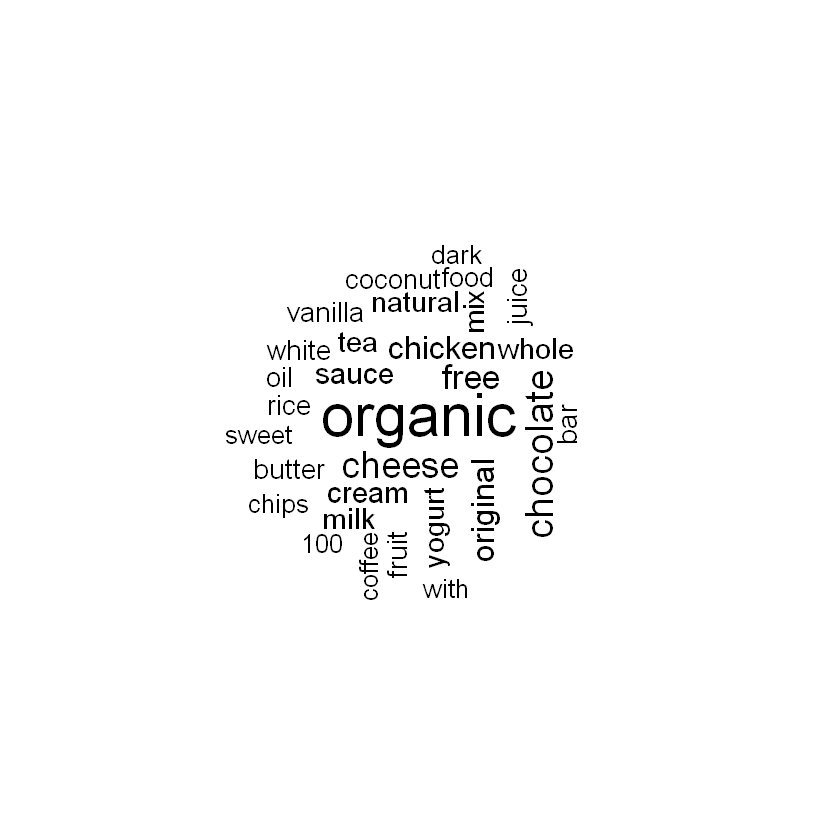

In [9]:
wordcloud(products$product_name, min.freq=100, scale=c(3,1), 
          random.color=T,max.words = 30, random.order=F)

In [10]:
products = products%>%
  mutate(is_organic = ifelse(str_detect(str_to_lower(products$product_name),'organic'),1,0))

products = products%>%
  mutate(is_gluten_free = ifelse(str_detect(str_to_lower(products$product_name),'gluten'), 1,0))

products = products%>%
  mutate(is_vegetarian = ifelse(str_detect(str_to_lower(products$product_name),'vegetarian'), 1,0))

products = products%>%
  mutate(is_dairy_free = ifelse(str_detect(str_to_lower(products$product_name),'dairy free'), 1,0))

products = products%>%
  mutate(is_vegan = ifelse(str_detect(str_to_lower(products$product_name),'vegan'), 1,0))

glimpse(products)
summary(products)

Observations: 49,688
Variables: 9
$ product_id     <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1...
$ product_name   <fct> Chocolate Sandwich Cookies, All-Seasons Salt, Robust...
$ aisle_id       <int> 61, 104, 94, 38, 5, 11, 98, 116, 120, 115, 31, 119, ...
$ department_id  <int> 19, 13, 7, 1, 13, 11, 7, 1, 16, 7, 7, 1, 11, 17, 18,...
$ is_organic     <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...
$ is_gluten_free <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...
$ is_vegetarian  <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...
$ is_dairy_free  <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...
$ is_vegan       <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...


   product_id                                    product_name  
 Min.   :    1   'Swingtop' Premium Lager              :    1  
 1st Qu.:12423   #2 Coffee Filters                     :    1  
 Median :24845   #2 Cone White Coffee Filters          :    1  
 Mean   :24845   #2 Mechanical Pencils                 :    1  
 3rd Qu.:37266   #4 Natural Brown Coffee Filters       :    1  
 Max.   :49688   & Go! Hazelnut Spread + Pretzel Sticks:    1  
                 (Other)                               :49682  
    aisle_id      department_id     is_organic     is_gluten_free   
 Min.   :  1.00   Min.   : 1.00   Min.   :0.0000   Min.   :0.00000  
 1st Qu.: 35.00   1st Qu.: 7.00   1st Qu.:0.0000   1st Qu.:0.00000  
 Median : 69.00   Median :13.00   Median :0.0000   Median :0.00000  
 Mean   : 67.77   Mean   :11.73   Mean   :0.1014   Mean   :0.01652  
 3rd Qu.:100.00   3rd Qu.:17.00   3rd Qu.:0.0000   3rd Qu.:0.00000  
 Max.   :134.00   Max.   :21.00   Max.   :1.0000   Max.   :1.00000  
     

### Build out the transaction data 

Concatenate the prior and training order dataframes to have a full set of transaction details
Before merging the dataframes, check of they have the same column structure

In [11]:
# Do the dataframes have the same column headers?
names(order_prior) == names(order_train)

[1] TRUE TRUE TRUE TRUE

In [12]:
# Column headers are the same.
# To avoid duplication of transaction data, check for order_id duplication in both dataframes
order_id_prior = order_prior %>%
  select(order_id) %>%
  unique()

order_id_train = order_train %>%
  select(order_id) %>%
  unique()

# If there is any duplication of order_id we will have to perform a dedupe of the data.
intersect(order_id_prior, order_id_train)

order_id


In [13]:
# Since there is no order_id duplication, we can safety perform a row-wise concatenation of the 2 dataframes
full.transactions = rbind(order_prior, order_train)

In [14]:
# Build a complete set of transactions, 
# To the SKU level transaction data, add the product information and the order information
full.transactions = full.transactions %>%
  left_join(products, by = "product_id")

# Add on order data
full.transactions = full.transactions %>%
  left_join(orders, by = "order_id")

### Build out the user data 

Examining the full_orders dataframe, we see that test orders do not appear in the transaction data,, they only appear in the orders dataframe. <br>
As we are concerned with complete transactions only to build out the user data, we can remove the test orders when developing the RFM matrix

In [15]:
full.orders = orders[orders$eval_set != "test",]

dim(orders)
dim(full.orders)
dim(orders[orders$eval_set == "test",])

[1] 3421083       7

[1] 3346083       7

[1] 75000     7

### Cannot develop an RFM matrix due to the absence of spend data.
We can however, use quantity of items as a proxy for testing under the assumption that larger numbers of items correspond to larger transaction values.

### Working out the "M" part of the RFM matrix

In [16]:
# Get the quantity of products in each order
quantity = full.transactions %>%
  group_by(order_id) %>%
  summarise(no_products = n())

# Add the order quantity to the order detail
full.orders = full.orders %>%
  left_join(quantity, by = "order_id")

# Sum the total items purchased by each user
quantity.items = full.orders %>%
  group_by(user_id) %>%
  summarise(total_products = sum(no_products))

# Summary to check for NA but OK!
summary(quantity.items)

    user_id       total_products
 Min.   :     1   Min.   :   3  
 1st Qu.: 51553   1st Qu.:  44  
 Median :103105   Median :  90  
 Mean   :103105   Mean   : 164  
 3rd Qu.:154657   3rd Qu.: 196  
 Max.   :206209   Max.   :3725  

### Working out the "R" part of the RFM matrix
R in RFM terms refers to recency: how recently the customer / user has made a transaction

In [17]:
recent = full.orders %>%
  group_by(user_id) %>%
  summarise(average_days_between_transactions = mean(days_since_prior_order, na.rm = TRUE))

### Working out the "F" part of the RFM matrix 
F in RFM terms refers to Frequency: how frequently does the customer / user make transactions

In [18]:
freq.transactions = full.orders %>%
  group_by(user_id) %>%
  summarise(no_transactions = n())

# Bringing the RFM data together

In [19]:
users.rfm = recent %>%
  left_join(freq.transactions, by = "user_id") %>%
  left_join(quantity.items, by = "user_id")

names(users.rfm) = c("user_id", "recency", "frequency", "quantity" )
head(users.rfm, 5)

user_id,recency,frequency,quantity
1,19.00000,11,70
2,16.28571,15,226
3,12.09091,12,88
4,13.75000,5,18
5,11.50000,5,46


# Working out the scoring rank of users for each of the RFM (RFQ) scores
RFM is scored on a scale from 1 - 10, where for:
- Recency: 1 = not recent, 10 = very recent
- Frequency: 1 = not frequent, 10 = very frequent
- Monetary (Quantity in this case): 1 = low quantity, 10 = high quantity

### Scoring methodolgy
First step is to split the range of values under each RFM heading in the number of groups: max_score <br>
Then scores are applied by bucketing users into each of their respective score band/quantiles.

In [20]:
max_score = 10

quant_score = seq(1, max_score)
quant_split = seq(0, 1, 1/max_score)
quants_recency = quantile(users.rfm$recency, quant_split)
quants_freq = quantile(users.rfm$frequency, quant_split)
quants_quantity = quantile(users.rfm$quantity, quant_split)

users.rfm$recency_score = as.numeric(cut(users.rfm$recency, quants_recency, quant_score))
users.rfm$freq_score = as.numeric(cut(users.rfm$frequency, quants_freq, quant_score))
users.rfm$quantity_score = as.numeric(cut(users.rfm$quantity, quants_quantity, quant_score))
users.rfm[is.na(users.rfm)] = 1
summary(users.rfm)

    user_id          recency         frequency         quantity   
 Min.   :     1   Min.   : 0.000   Min.   :  3.00   Min.   :   3  
 1st Qu.: 51553   1st Qu.: 9.667   1st Qu.:  6.00   1st Qu.:  44  
 Median :103105   Median :14.800   Median : 10.00   Median :  90  
 Mean   :103105   Mean   :15.361   Mean   : 16.23   Mean   : 164  
 3rd Qu.:154657   3rd Qu.:20.500   3rd Qu.: 20.00   3rd Qu.: 196  
 Max.   :206209   Max.   :30.000   Max.   :100.00   Max.   :3725  
 recency_score     freq_score     quantity_score  
 Min.   : 1.00   Min.   : 1.000   Min.   : 1.000  
 1st Qu.: 3.00   1st Qu.: 3.000   1st Qu.: 3.000  
 Median : 5.00   Median : 5.000   Median : 5.000  
 Mean   : 5.49   Mean   : 5.304   Mean   : 5.485  
 3rd Qu.: 8.00   3rd Qu.: 8.000   3rd Qu.: 8.000  
 Max.   :10.00   Max.   :10.000   Max.   :10.000  

Add the dietary preferences to RFM data

In [21]:
# Describe customers with special dietary needs
user.diet = full.transactions %>%
  group_by(user_id) %>%
  summarise(
    organic.pref = mean(is_organic),
    gluten.pref = mean(is_gluten_free),
    veg.pref = mean(is_vegetarian), 
    dairy.pref = mean(is_dairy_free), 
    vegan.pref = mean(is_vegan)
  )

# Users with a specific dietary need: gluten free / vegetarian / dairy free will be tagged as having a preferene (0 , 1)
# Users with a preference for organic will be tagged with the proportion of organic products they purchase.

user.diet$gluten.pref = (user.diet$gluten.pref > 0) * 1
user.diet$veg.pref = (user.diet$veg.pref > 0) * 1
user.diet$dairy.pref = (user.diet$dairy.pref > 0) * 1
user.diet$vegan.pref = (user.diet$vegan.pref > 0) * 1

# Bringing together RFM data with behvaioural data.
# We will join RFM with preferred shopping time, preferred shopping day and dietary preferences

users.rfm = users.rfm %>%
  left_join(user.diet)

Joining, by = "user_id"


### Building a usable Sample dataset

The dataset is 33M+ observation, so we take a subset to develop our cluster input. <br>
1. Start by identifying a subset of customers and selecting their transactions

There are 206,209 users, so we can take a sample of 10% for computational testing.

In [22]:
glimpse(users.rfm)

set.seed(1)
sample_size = 0.05
mask = sample(1:nrow(users.rfm), round(nrow(users.rfm) * sample_size, 0))
sample.users = users.rfm[mask,]$user_id
sample.orders = full.orders[full.orders$user_id %in% sample.users,]$order_id
sample.data = full.transactions[full.transactions$order_id %in% sample.orders,]

Observations: 206,209
Variables: 12
$ user_id        <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1...
$ recency        <dbl> 19.000000, 16.285714, 12.090909, 13.750000, 11.50000...
$ frequency      <int> 11, 15, 12, 5, 5, 3, 21, 4, 4, 6, 7, 5, 13, 14, 22, ...
$ quantity       <int> 70, 226, 88, 18, 46, 14, 215, 67, 98, 147, 94, 74, 8...
$ recency_score  <dbl> 7, 6, 4, 5, 4, 3, 3, 9, 9, 8, 8, 9, 2, 8, 4, 8, 2, 1...
$ freq_score     <dbl> 6, 7, 6, 2, 2, 1, 8, 1, 1, 3, 4, 2, 6, 7, 8, 3, 10, ...
$ quantity_score <dbl> 5, 8, 5, 1, 3, 1, 8, 4, 6, 7, 6, 5, 5, 8, 5, 5, 9, 3...
$ organic.pref   <dbl> 0.257142857, 0.247787611, 0.340909091, 0.111111111, ...
$ gluten.pref    <dbl> 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0...
$ veg.pref       <dbl> 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1...
$ dairy.pref     <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0...
$ vegan.pref     <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...


### Breakdown by category
Get a total number of products purchased per department per user

In [23]:
user.categories = sample.data %>%
  select(user_id,department_id) %>%
  left_join(departments, by = "department_id") %>%
  group_by(user_id, department) %>%
  summarise(
    count = n()
  ) 
summary(user.categories)

    user_id            department        count        
 Min.   :    15   produce   : 9716   Min.   :   1.00  
 1st Qu.: 49299   dairy eggs: 9602   1st Qu.:   2.00  
 Median :102281   snacks    : 8822   Median :   5.00  
 Mean   :102310   beverages : 8808   Mean   :  14.77  
 3rd Qu.:154887   pantry    : 8786   3rd Qu.:  14.00  
 Max.   :206193   frozen    : 8317   Max.   :1134.00  
                  (Other)   :59981                    

### Breakdown by sub-category
Get a total number of products purchased per sub-category per user

In [24]:
# Breakdown by sub-category
user.subcategories = sample.data %>%
  select(department_id, aisle_id) %>%
  arrange(department_id, aisle_id) %>%
  left_join(aisles, by = "aisle_id") %>%
  left_join(departments, by = "department_id") %>%
  select(department_id, department, aisle_id, aisle) %>%
  group_by(department_id, department, aisle_id, aisle) %>%
  summarise(
    count = n()
  ) %>%
  arrange(desc(count))

sample.users = users.rfm[users.rfm$user_id %in% sample.users,]

Emulate one hot encoding by building a wide dataframe which will show observations of users with total quantity of items purchased in each department.

In [25]:
ohe.users = spread(user.categories, key = department, value = count, fill = 0)
ohe.users = ohe.users %>% 
  drop_na()

# separate the user_id column from the user data.
user.data = ohe.users %>%
  left_join(user.diet)

Joining, by = "user_id"


### Due the large size of the data files, it may be necessary to remove these from working memory in order to maintain efficient processing<br>
Sorting by object size and whether or not the objects are relevant from this point onwards, we can remove some larger objects from memory.

In [26]:
vars = ls()
size_of_objects_a = sapply(vars, function(x) format(object.size(get(x)), unit = 'auto'))
size_of_objects_b = sapply(vars, function(x) object.size(get(x)))
size_of_objects = data.frame(vars, size_of_objects_a, size_of_objects_b)
size_of_objects = size_of_objects %>%
  arrange(desc(size_of_objects_b))
size_of_objects
rm(list = c("full.transactions", "order_prior", "full.orders", "orders", "quantity", "order_id_prior", "order_train"))

vars,size_of_objects_a,size_of_objects_b
full.transactions,3 Gb,3251421056
order_prior,494.9 Mb,518952976
sample.data,165.2 Mb,173219824
full.orders,114.9 Mb,120461256
orders,104.4 Mb,109476808
quantity,25.5 Mb,26769672
order_id_prior,24.5 Mb,25719720
order_train,21.1 Mb,22155024
users.rfm,16.5 Mb,17323896
user.diet,8.7 Mb,9074704


### Investigate the clustering of user data based on the different linkage varieties to decide if one method is superior.
All examples use scaled data, as some departments are inherantly more commonly used than others.

scaled.user
    1     2     3     4     5     6 
10249     9     4    38     8     2 

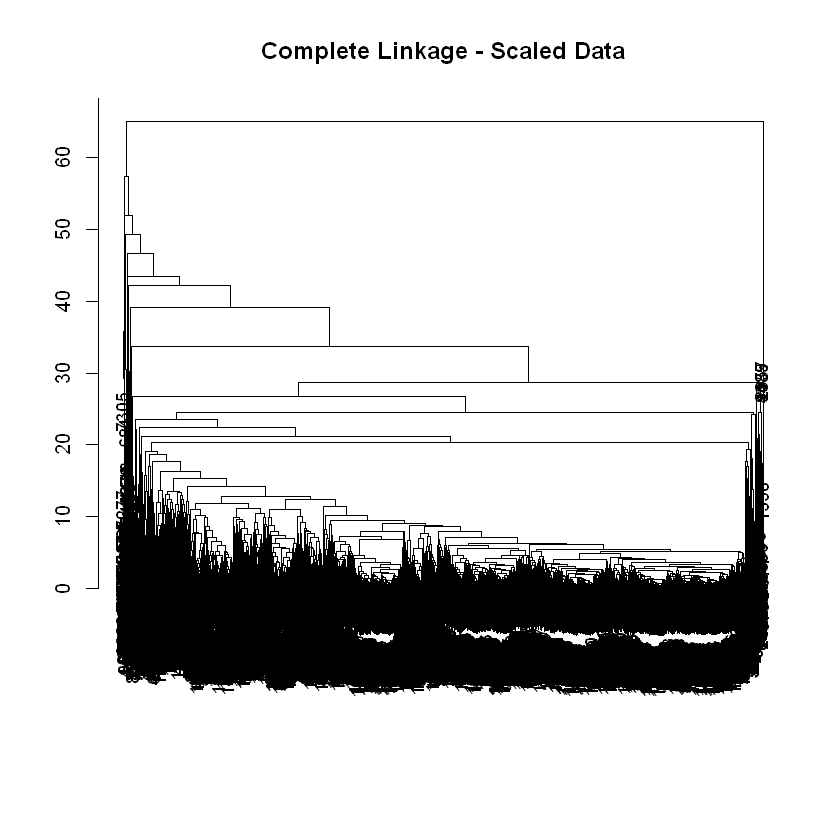

In [27]:
# Complete Linkage using transactional data
h.clust_comp = hclust(dist(scale(user.data[-1])), method = "complete")
plot(h.clust_comp,main = "Complete Linkage - Scaled Data", xlab = "", ylab = "", sub = "", cex = 0.9)
scaled.user = cutree(h.clust_comp, 6)
table(scaled.user)

### We can see that none of these clustering model are not very useful to identify a diverse set of users.
We have other options with hierarchical clustering e.g. correlation based rather distance based clustering.
This may be more practical in this environment where we want to identify customers with similar behaviour rather than similar traits.

samp.cut
   1    2    3    4    5    6 
1562 7021 1101  147  242  237 

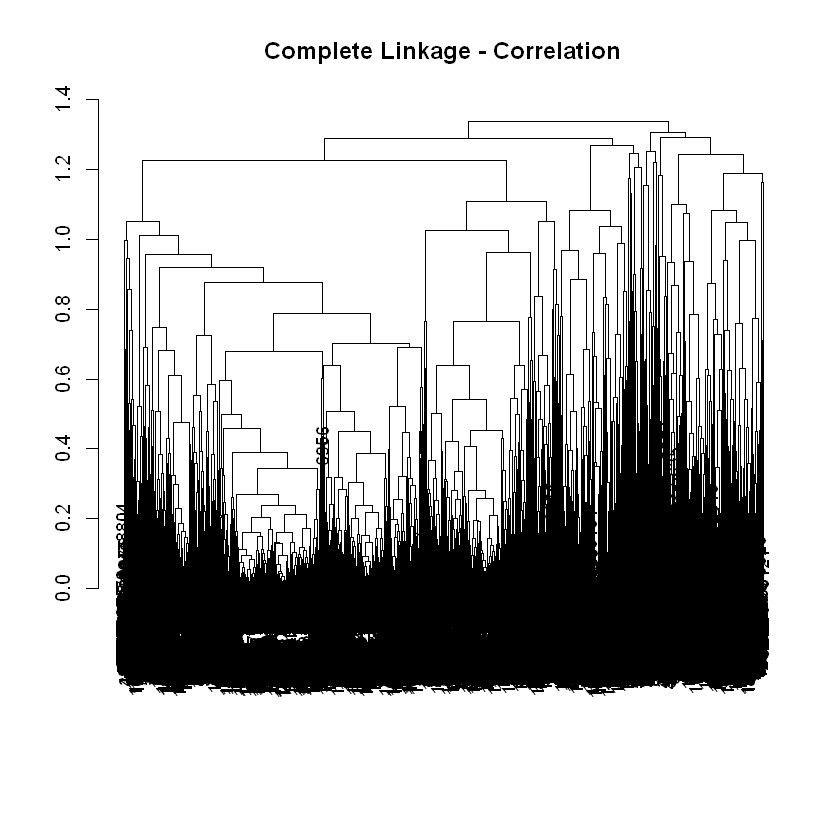

In [28]:
# Cluster based on correlated data and complete linkage
samp_dist = as.dist(1-cor(t(user.data[-1])))
h.clust_cor = hclust(samp_dist, method = "complete")
plot(h.clust_cor, main = "Complete Linkage - Correlation", xlab = "", ylab = "", sub = "", cex = 0.9)
samp.cut = cutree(h.clust_cor, 6)
table(samp.cut)

### K-Means Clustering
Given that the first attempts using hierarchical clustering did not give any insightful groupings using the transactional data and due to the time/space requirements, we can move to K-Means.<br>
K-Means being very popular and using numerical data, we should expect customers with similar buying patterns to be grouped closely in n-dimensional space. <br>

Examining the distributions of each feature shows that RFM scores are quite evenly spread as expected due to the quantile approach. Low numbers of customers have bought vegan or vegetarian products but organic and gluten free have strong preferences.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


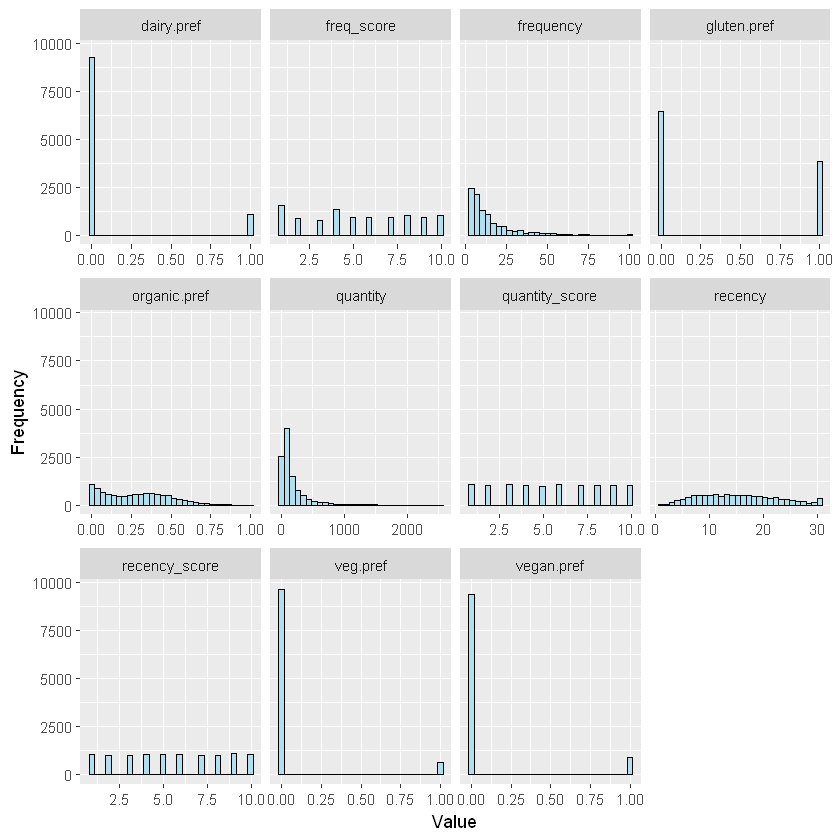

In [29]:
sample.users[-c(1)] %>%
  gather(Attributes, value, 1:11) %>%
  ggplot(aes(x = value)) +
  geom_histogram(fill = "lightblue2", color = "black") +
  facet_wrap(~Attributes, scales = "free_x") +
  labs(x = "Value", y = "Frequency")

Gluten Free preference has a moderate positive correlation with quantity suggesting that customer that buy more have a tendency to buy gluten free products. Also customers with a high recency score have a negative correlation with volume and frequency. This is in line with intuition that customers with higher frequency and quantity would be more likely to have shopped recently.

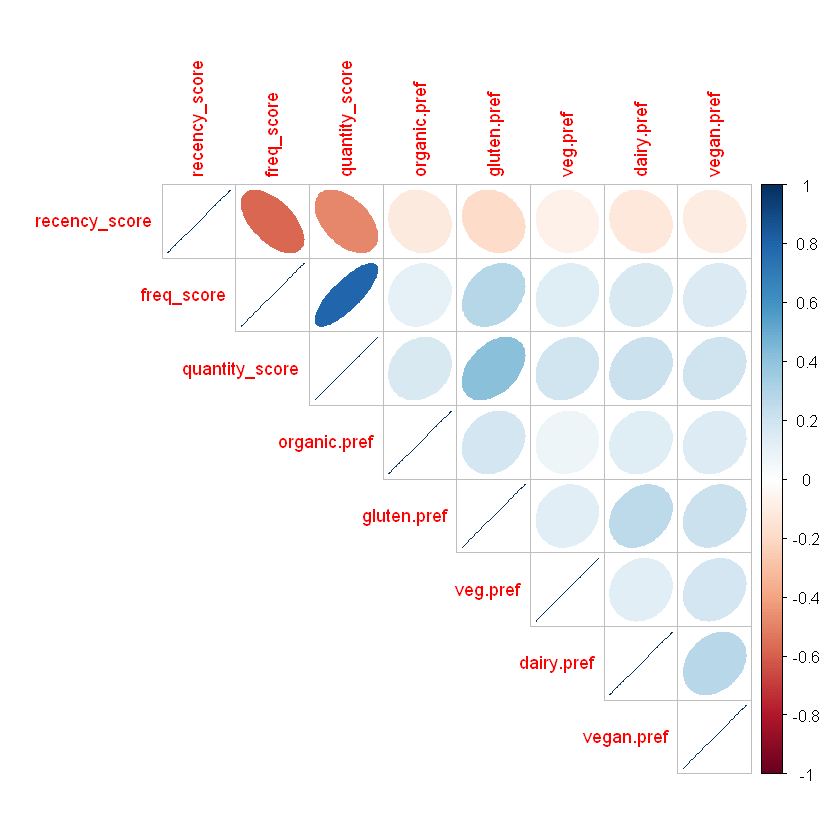

In [48]:
# Explore correlated variables
corrplot(cor(scale(sample.users[-c(1, 2, 3, 4)])), type = "upper", method = "ellipse", tl.cex = 0.9)

We investigate the importance of each feature by using Principle Component Analysis. <br>
Excluding columns 1 - 4: user_id, recency value, frequency value, quantity value. <br>
For this portion of the analysis we are concerned with RFM scores rather than their corresponding value.

Examining the scree plot we see that PC1 explains 34.4% of the variance in the data. <br>
PC2 to PC5 have similar values with PC6 to PC8 not very meaningful.
Examining the clustering in the context of PC1 to PC5 should give some visual insight into the effectiveness of the process.

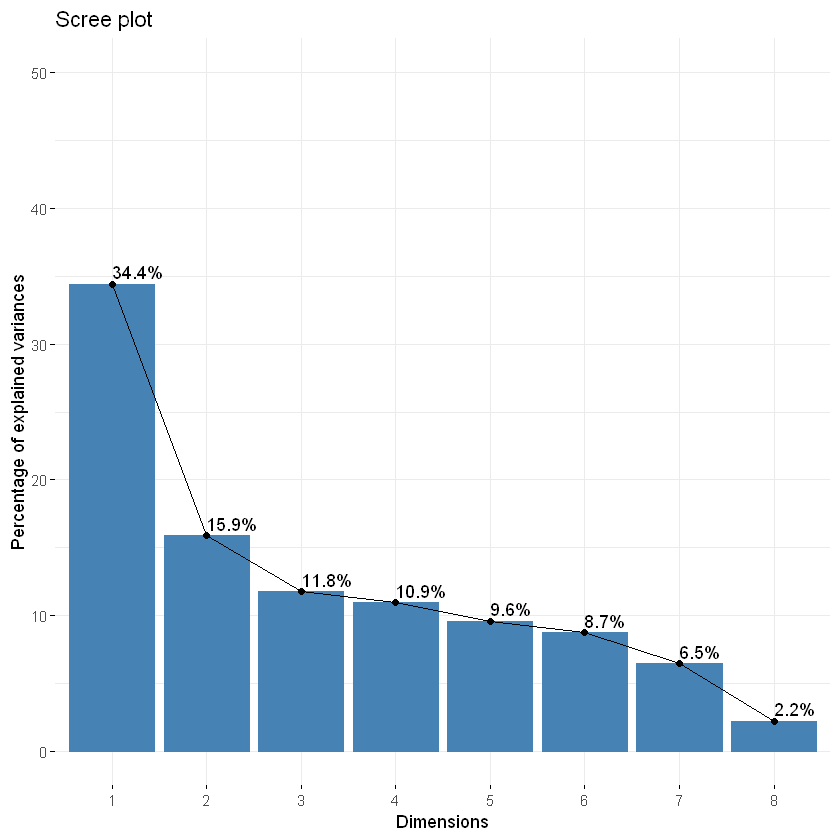

In [30]:
# Perform PCA, exluding RFM values - when scaled they add no additional value to the quantiled scores.
res.pca = PCA(scale(sample.users[-c(1,2,3,4 )]), graph = FALSE)

# Screeplot shows 82.5% of variability can be explained with the first 5 principle components
# 72.9% with the first 4 principle components
fviz_screeplot(res.pca, addlabels = TRUE, ylim = c(0, 50))

We can investigate which variables are most significant to each of the principle components. <br>
For PC1, frequency and quantity are the most significant with recency not as important.

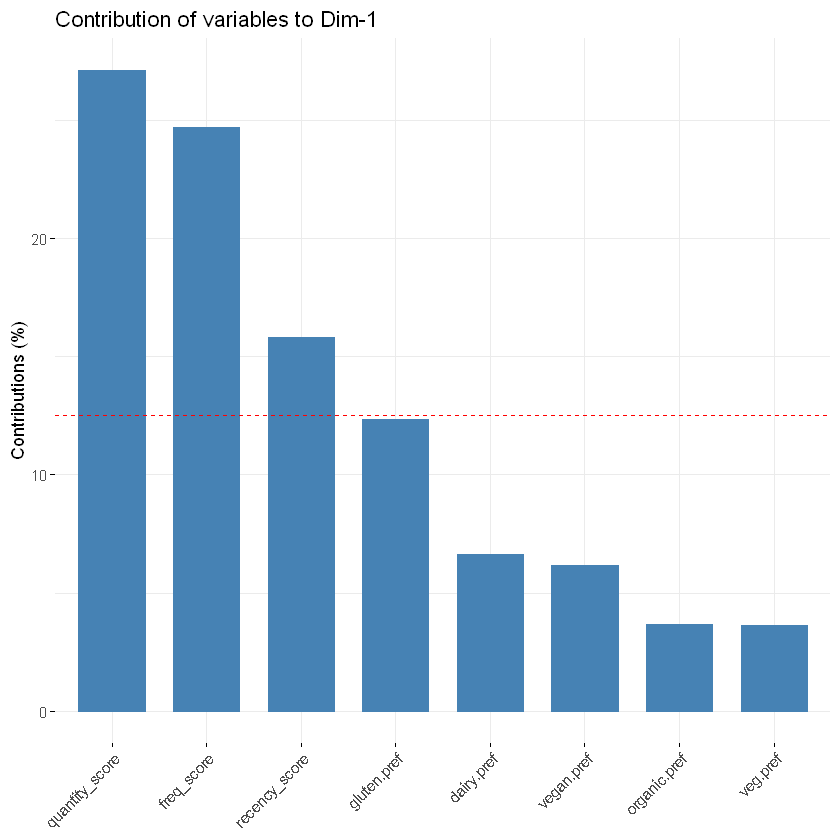

In [31]:
# Get the contributions of each variable to the principle components
var <- get_pca_var(res.pca)

# PC1 is contributed to, mainly, by RFM scores.
fviz_contrib(res.pca, choice = "var", axes = 1 , top = 10)

PC2 is contributed to, mainly, by vegan preference and dairy preference. <br>
Quantity does not effect PC2. moreso frequency of purchase and recency of purchase.

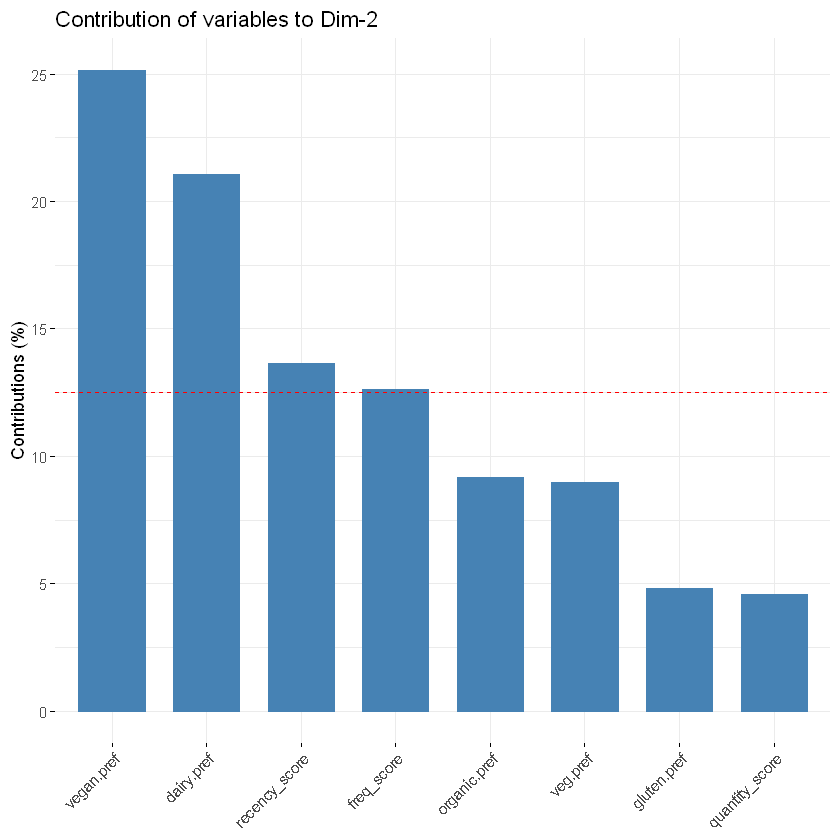

In [32]:
fviz_contrib(res.pca, choice = "var", axes = 2 , top = 10)

PC3 is contributed to, mainly, by vegetarian preference and organic preference.

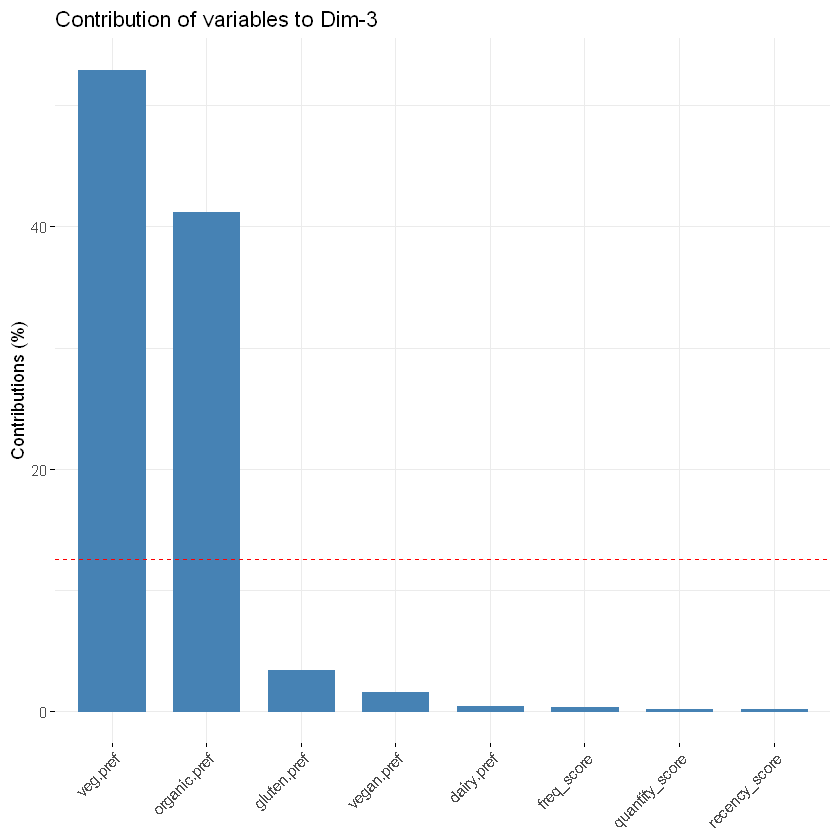

In [33]:
fviz_contrib(res.pca, choice = "var", axes = 3 , top = 10)

Separation on the x-axis of PC1 vs PC2 is mostly effected by RFM, but y-axis is effected by dietary preference. 

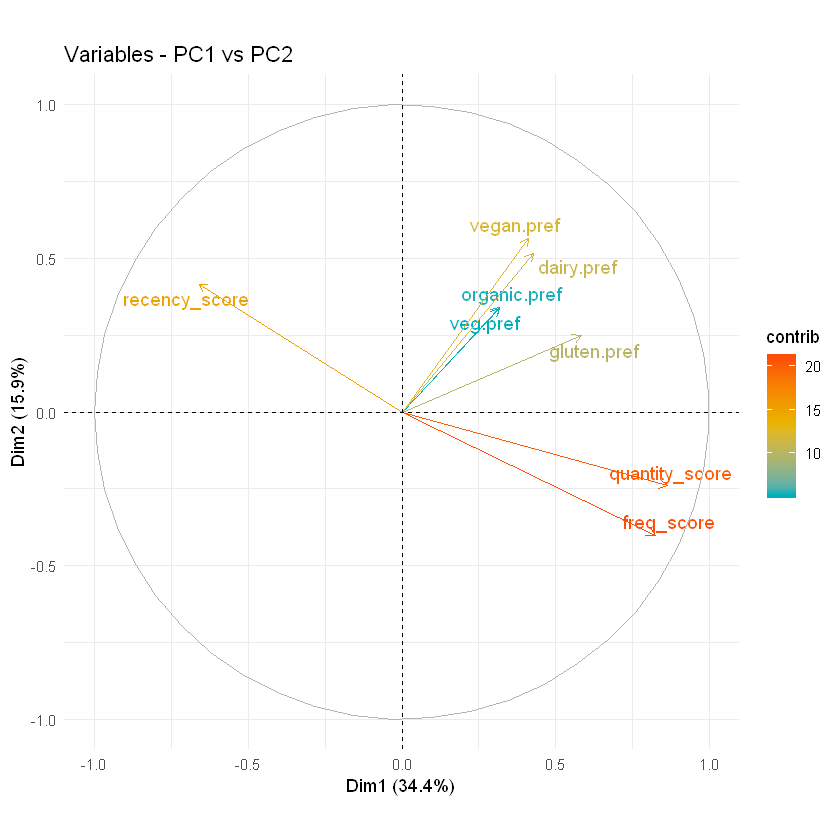

In [35]:
fviz_pca_var(res.pca, col.var="contrib", axes = c(1, 2),
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             repel = TRUE # Avoid text overlapping
             ) + theme_minimal() + ggtitle("Variables - PC1 vs PC2")

Separation on the x-axis of Pc1 vs PC3 is mostly effected by RFM. <br>
Positive values effected by vegetarian and vegan preference. <br>
Negative values effected by dairy, gluten free and organic preferences.

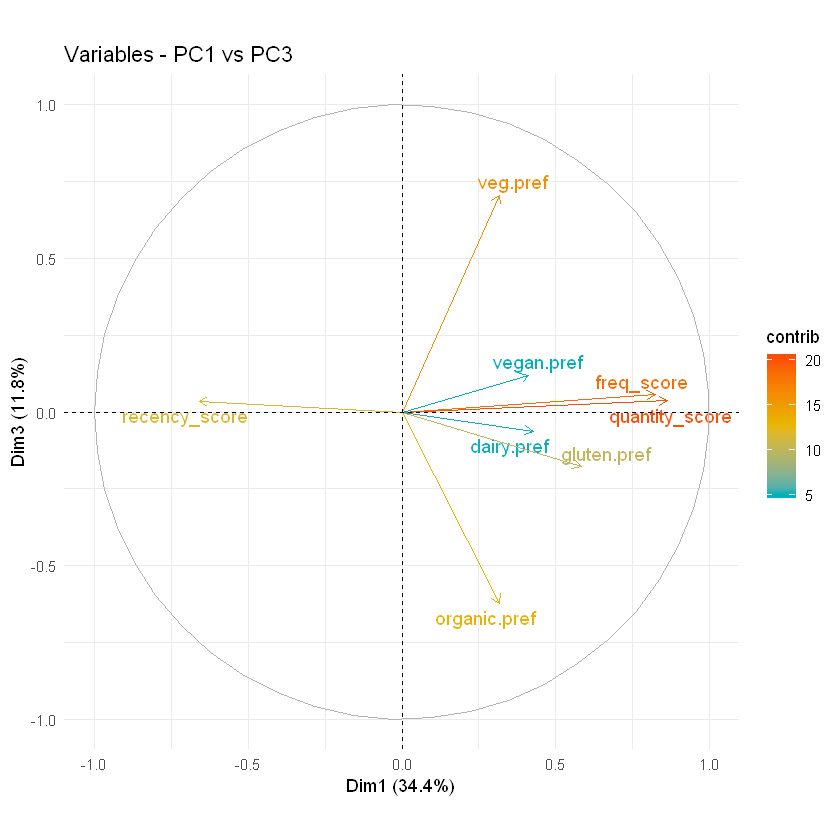

In [36]:
fviz_pca_var(res.pca, col.var="contrib", axes = c(1, 3),
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             repel = TRUE # Avoid text overlapping
) + theme_minimal() + ggtitle("Variables - PC1 vs PC3")

Separation on the x-axis of PC2 vs PC3 is mostly effected by RFM, but separation is not as pronouned as other PCA views. <br>
Y-Axis values are the same as above.

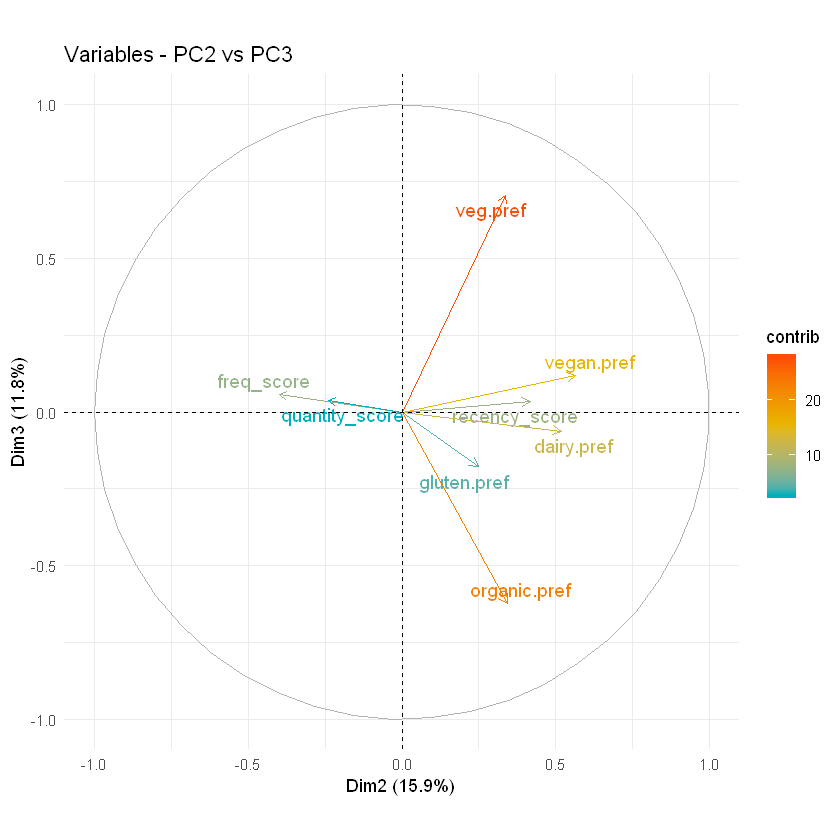

In [38]:
fviz_pca_var(res.pca, col.var="contrib", axes = c(2, 3),
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             repel = TRUE # Avoid text overlapping
) + theme_minimal() + ggtitle("Variables - PC2 vs PC3")

The below function is used compute total within-cluster sum of squares <br>
Using the elbow method, the optimal number of clusters is between 4 and 6. <br>
We are looking for the a sweet spot between minimising the value of K and minimising the total within sum of squares.

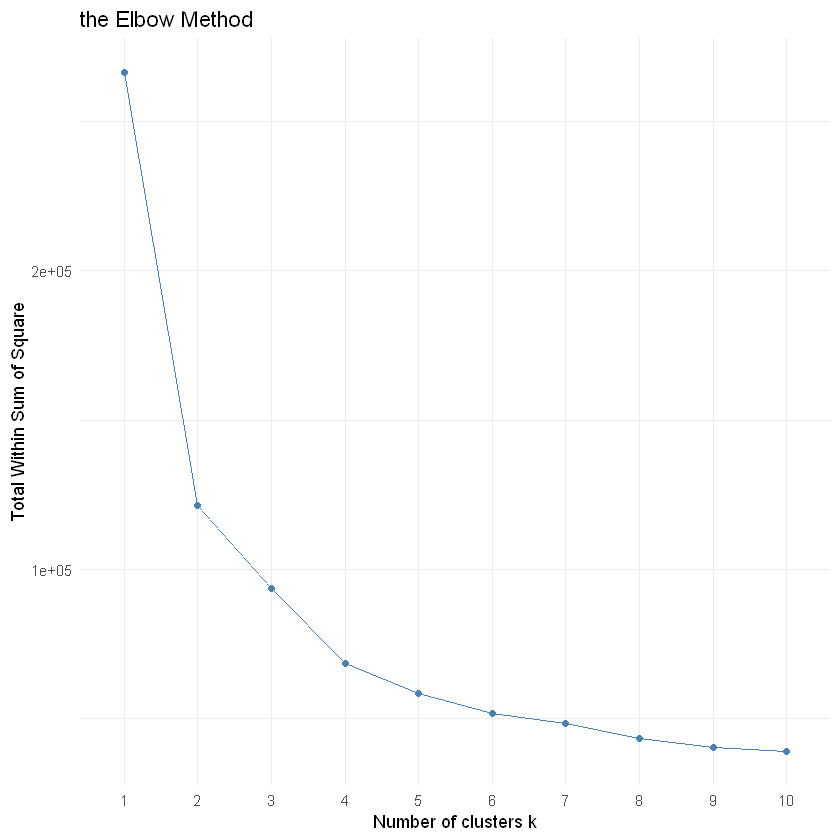

In [37]:
set.seed(1)
fviz_nbclust(sample.users[-c(1, 2, 3, 4)], kmeans, method = "wss", k.max = 10) + theme_minimal() + ggtitle("the Elbow Method")

The Gap statistic is calculated by comparing the total within cluster sum of squares for the data and comparing to a null reference distribution with no meaningful clustering. <br>
The ideal value for the Gap Statistic is where the difference in total within cluster sum of squares is maximised.<br>
Gap Statistic suggest that the optimal number of clusters is between 4 and 6.

Warning message:
"did not converge in 10 iterations"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 515500)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 515500)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 515500)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 515500)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 515500)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 515500)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 515500)"Warning message:
"did not converge in 10 iterations"Warning message:
"did not converge in 10 iterations"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 515500)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 515500)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 515500)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 515500)"Warning message:
"Quick-TRANSfer stage st

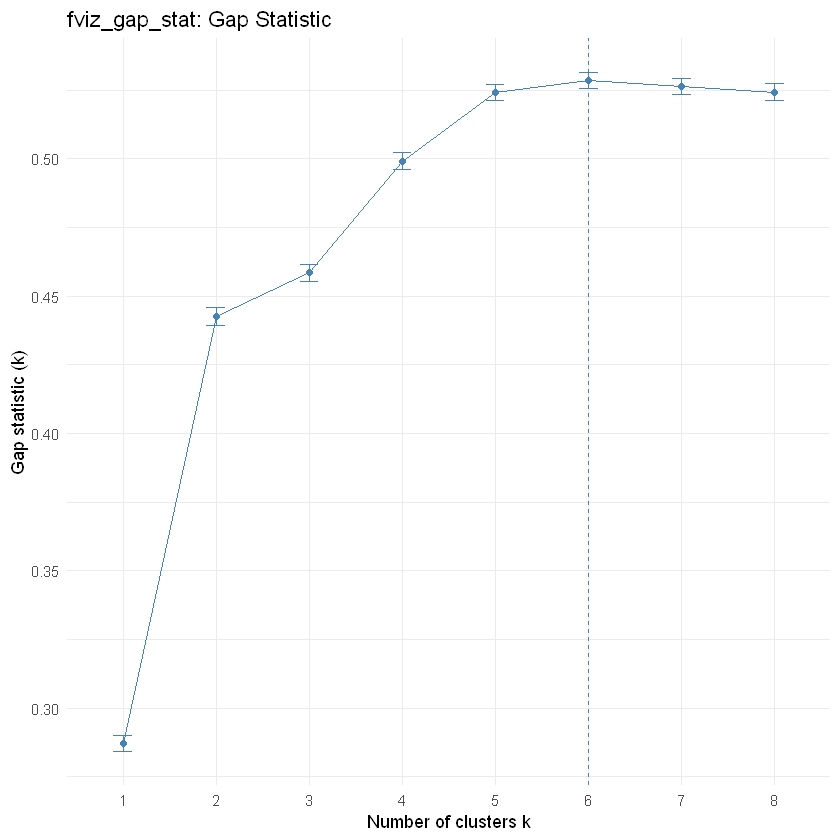

In [65]:
gap.stat <- clusGap(sample.users[-c(1, 2, 3, 4)], FUN = kmeans, nstart = 30, K.max = 8, B = 50)
fviz_gap_stat(gap.stat) + theme_minimal() + ggtitle("fviz_gap_stat: Gap Statistic")

The silhouette value represents the quality of clustering by calculating the distance between: <br> 
    <li>a point and all the points in the current cluster and <br>
    <li>comparing to the distance between all points in the nearest cluster. <br>
The Silhouette method suggests that the optimal number of clusters is 2

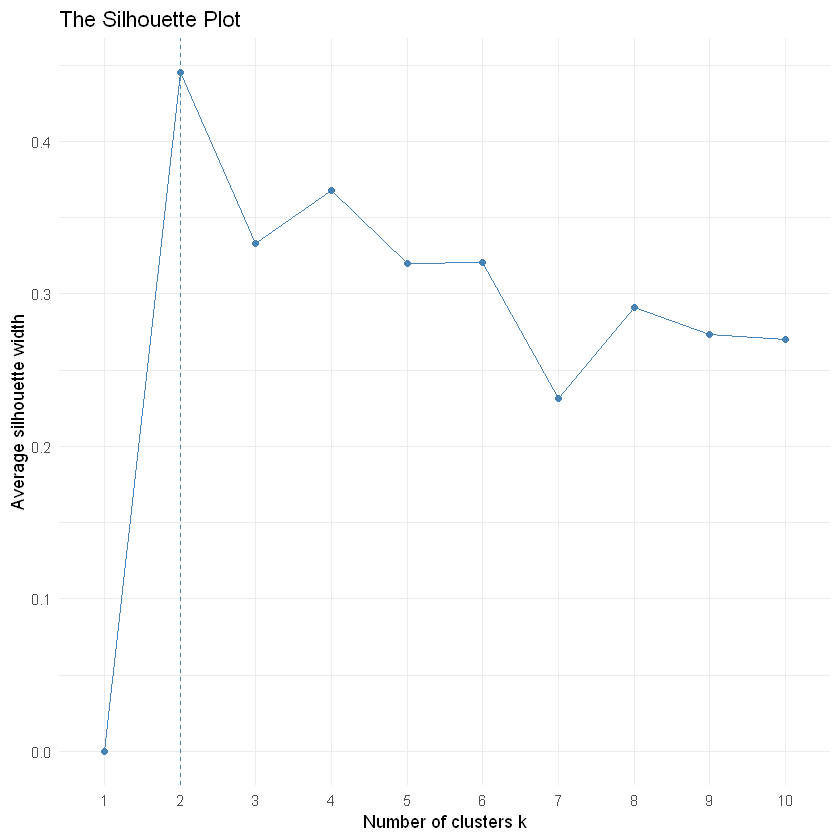

In [39]:
fviz_nbclust(sample.users[-c(1, 2, 3, 4)], kmeans, method = "silhouette", k.max = 10) + theme_minimal() + 
  ggtitle("The Silhouette Plot")

Within Sum of Squares vs Between Sum of Squares: <br>
This method aims to minimise the within-cluster sum of squares and maximise the between cluster sum of squares.<br>
We do this by visually comparing the rate of change of increase of between cluster sum of squares and the reduction
of within cluster sum of squares. <br>
After k = 4, the between sum of squares shows marginal increase for larger values of k.<br>
Even with a decreasing value of within sum of squares, we should use a smaller value of k.<br>
In this case, 4.

In [42]:
set.seed(1)
km1 = kmeans(sample.users[-c(1, 2, 3, 4)], 1, nstart = 25)
km2 = kmeans(sample.users[-c(1, 2, 3, 4)], 2, nstart = 25)
km3 = kmeans(sample.users[-c(1, 2, 3, 4)], 3, nstart = 25)
km4 = kmeans(sample.users[-c(1, 2, 3, 4)], 4, nstart = 25)
km5 = kmeans(sample.users[-c(1, 2, 3, 4)], 5, nstart = 25)
km6 = kmeans(sample.users[-c(1, 2, 3, 4)], 6, nstart = 25)
km7 = kmeans(sample.users[-c(1, 2, 3, 4)], 7, nstart = 25)
km8 = kmeans(sample.users[-c(1, 2, 3, 4)], 8, nstart = 25)
km9 = kmeans(sample.users[-c(1, 2, 3, 4)], 9, nstart = 25)
km10 = kmeans(sample.users[-c(1, 2, 3, 4)], 10, nstart = 25)

kms = data.frame(km1$cluster, km2$cluster, km3$cluster, km4$cluster, km5$cluster, km6$cluster, 
                   km7$cluster, km8$cluster)

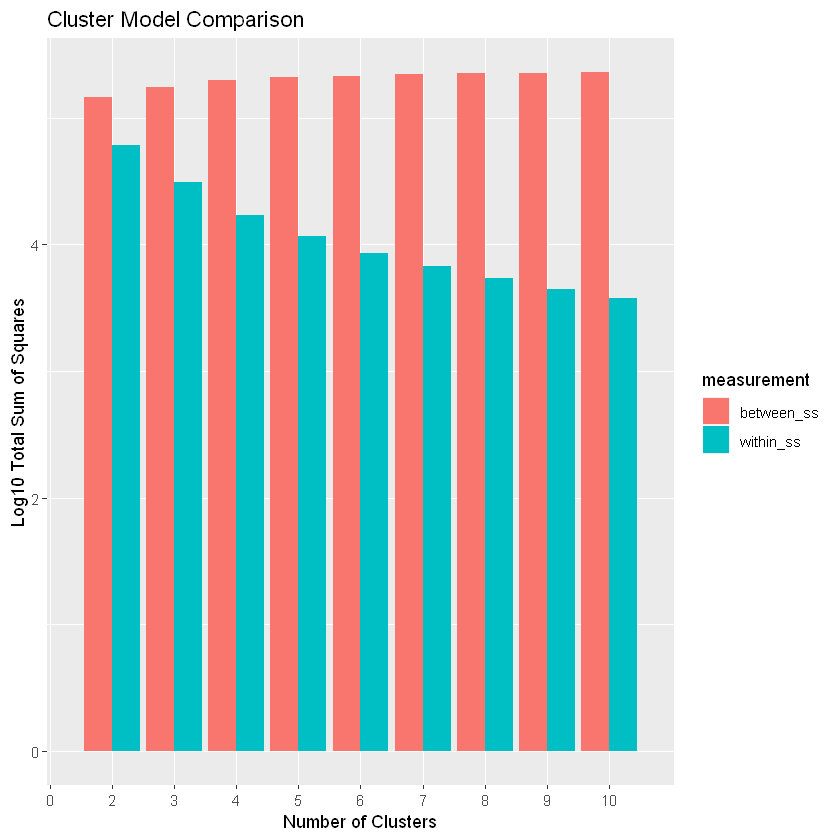

In [47]:
# Dataframe to hold within and between distances
ssc = data.frame(
  kmeans = c(2,3,4,5,6,7,8, 9, 10),
  within_ss = c(mean(km2$withinss), mean(km3$withinss), mean(km4$withinss), mean(km5$withinss), 
                mean(km6$withinss), mean(km7$withinss), mean(km8$withinss), mean(km9$withinss), mean(km10$withinss)),
  between_ss = c(km2$betweenss, km3$betweenss, km4$betweenss, km5$betweenss, 
                 km6$betweenss, km7$betweenss, km8$betweenss, km9$betweenss, km10$betweenss)
)

# Tabulate the within and between values.
ssc = ssc %>% gather(., key = "measurement", value = value, -kmeans)

ssc %>% ggplot(., aes(x=kmeans, y=log10(value), fill = measurement)) + 
  geom_bar(stat = "identity", position = "dodge") + 
  ggtitle("Cluster Model Comparison") + xlab("Number of Clusters") + 
  ylab("Log10 Total Sum of Squares") + 
  scale_x_discrete(name = "Number of Clusters", limits = c("0","2", "3", "4", "5", "6", "7", "8", "9", "10"))

Using Clustree, we can examine the direction that datapoints change betwen clustersfor different values of K. <br>
In this instance, For a value of K = 4, each proceeding branch has little movement among other branches and tend to start within the same grouping.

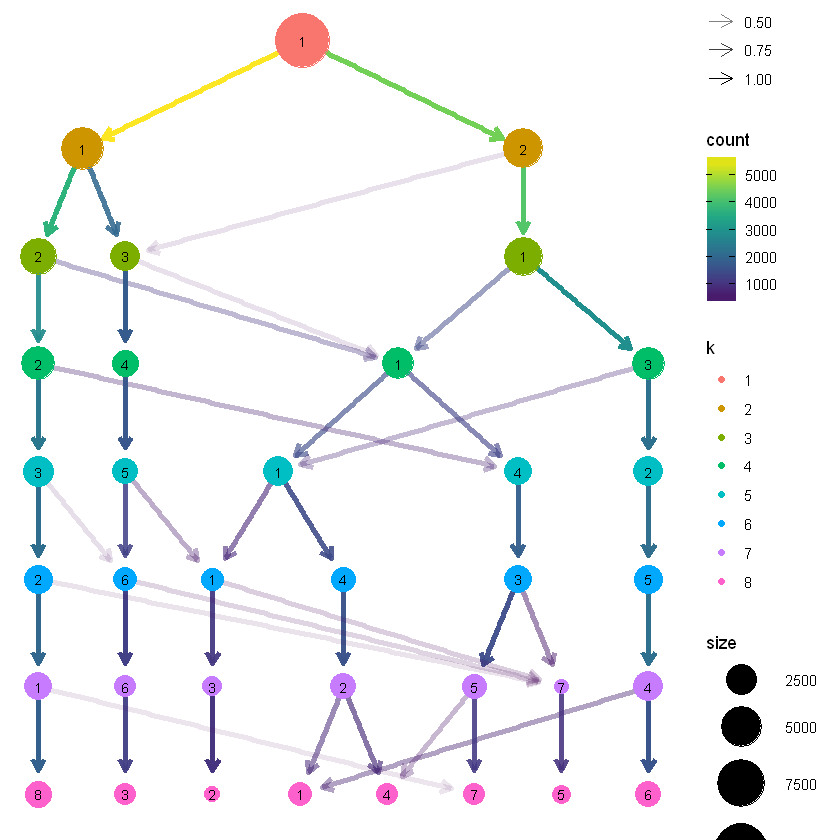

In [49]:
# add a prefix to the column names
names(kms) = seq(1:8)
names(kms) = paste0("k",colnames(kms))

# get individual PCA values
kms.pca = prcomp(kms, center = TRUE, scale. = FALSE)
ind.coord = kms.pca$x
ind.coord = ind.coord[,1:2]

# bind the dataframes 
df = bind_cols(as.data.frame(kms), as.data.frame(ind.coord))

# Generate the cluster tree
clustree(df, prefix = "k")

Based on the preceeding tests, the best value of K appears to be 4. <br>
Performing a kmeans clustering for K = 4.

In [51]:
set.seed(1)
km.res = eclust(sample.users[-c(1, 2, 3, 4)], "kmeans", k = 4, nstart = 25, graph = FALSE)

Examing the clustering across the 1st 5 meaningful principle components.

For PC1 vs PC2, there appears to be 3 distinct clusters ( from the legend below)
<li>(1 & 3)
    <li>4
        <li>2.

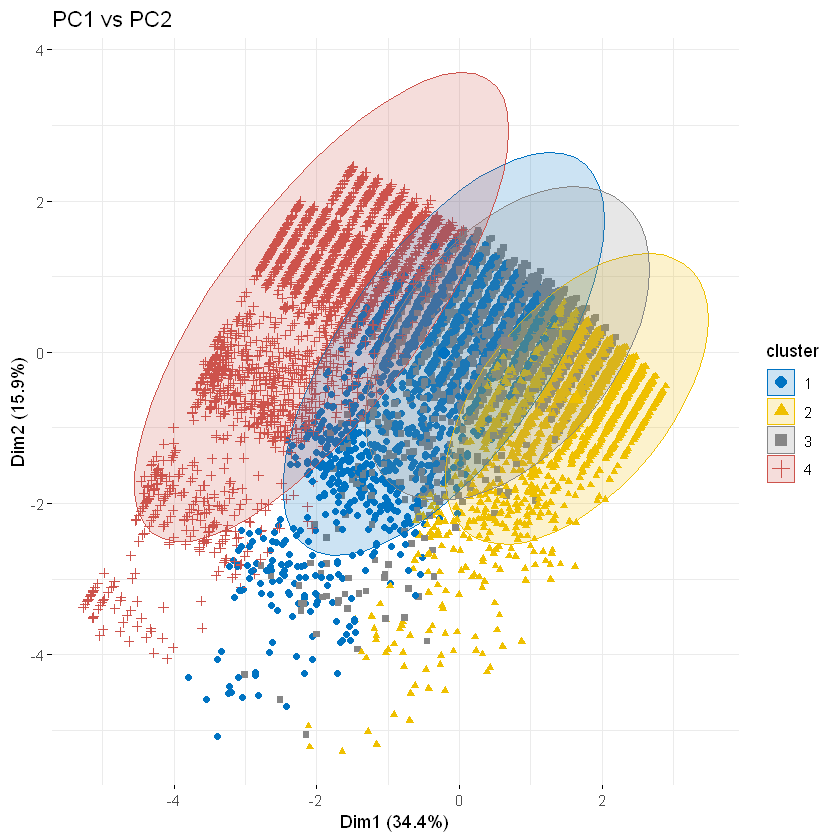

In [55]:
fviz_cluster(km.res, axes = c(1, 2),geom = "point", ellipse.type = "norm", palette = "jco", ggtheme = theme_minimal(), main = "PC1 vs PC2")

For PC1 vs PC3, there appears to be 3 distinct clusters ( from the legend below)
<li>(1 & 3) - slightly more separated than with PC2.
    <li>4
        <li>2.

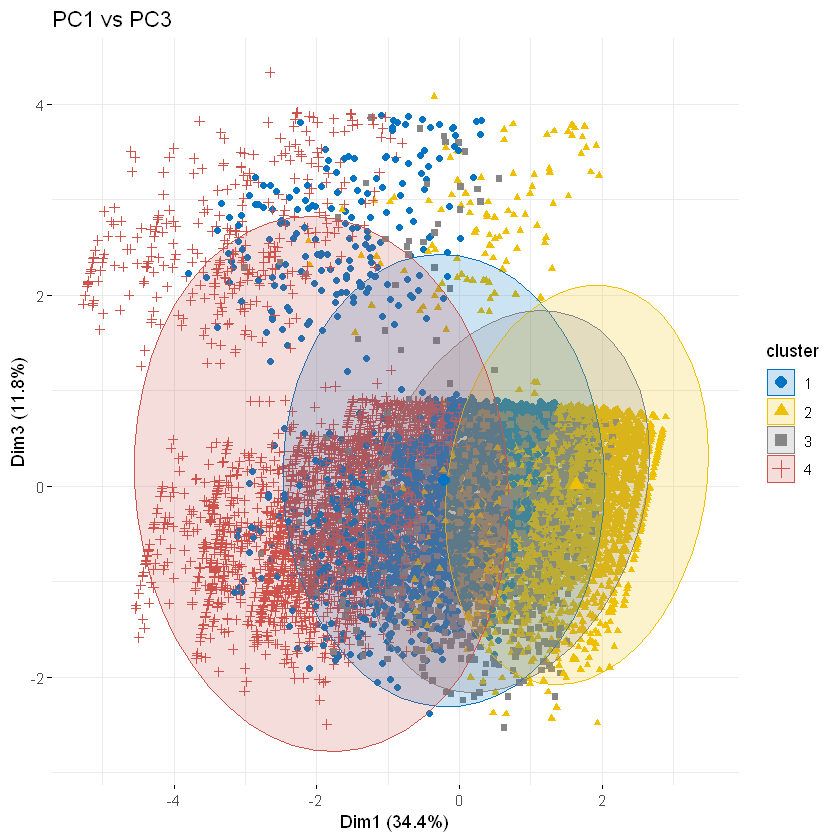

In [54]:
fviz_cluster(km.res, axes = c(1, 3),geom = "point", ellipse.type = "norm", palette = "jco", ggtheme = theme_minimal(), main = "PC1 vs PC3")

For PC1 vs PC4, there appears to be 3 distinct clusters ( from the legend below)
<li>(1 & 3)
    <li>4
        <li>2.

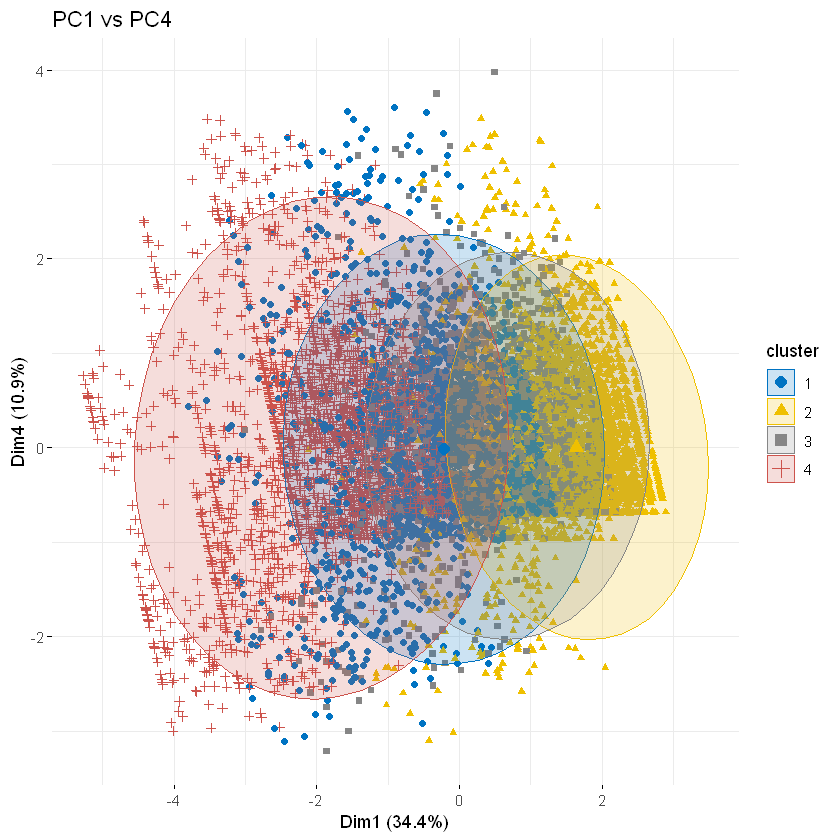

In [53]:
fviz_cluster(km.res, axes = c(1, 4),geom = "point", ellipse.type = "norm", palette = "jco", ggtheme = theme_minimal(), main = "PC1 vs PC4")


For PC1 vs PC2, there appears to be 3 distinct clusters ( from the legend below)
<li>(1 & 5) - further separation than PC1 vs PC3.
    <li>4
        <li>2.

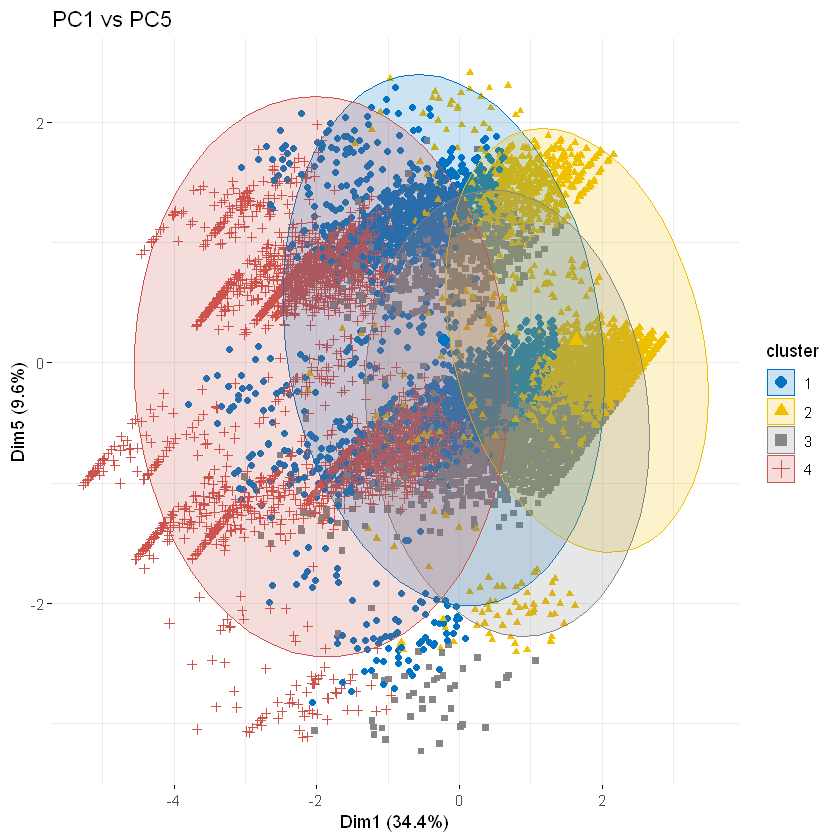

In [62]:
fviz_cluster(km.res, axes = c(1, 5),geom = "point", ellipse.type = "norm", palette = "jco", ggtheme = theme_minimal(), main = "PC1 vs PC5")

Generate a silhouette plot for K = 4 to validate the separation between clusters. <br>
There separation between  1 and 3 is not as meaningful as 2 and 4 but a value of almost 0.3 for both does suggest that there are distinctions between the groups.<br>
This will become more evident when we investigate the actual differences in the cluster summary. <br>
Overall, an average silhouette width of 0.37 does indicate reasonablly significant clustering with some minor misclassfication in clusters 1 and 3.

  cluster size ave.sil.width
1       1 2630          0.27
2       2 3043          0.40
3       3 1734          0.29
4       4 2903          0.46


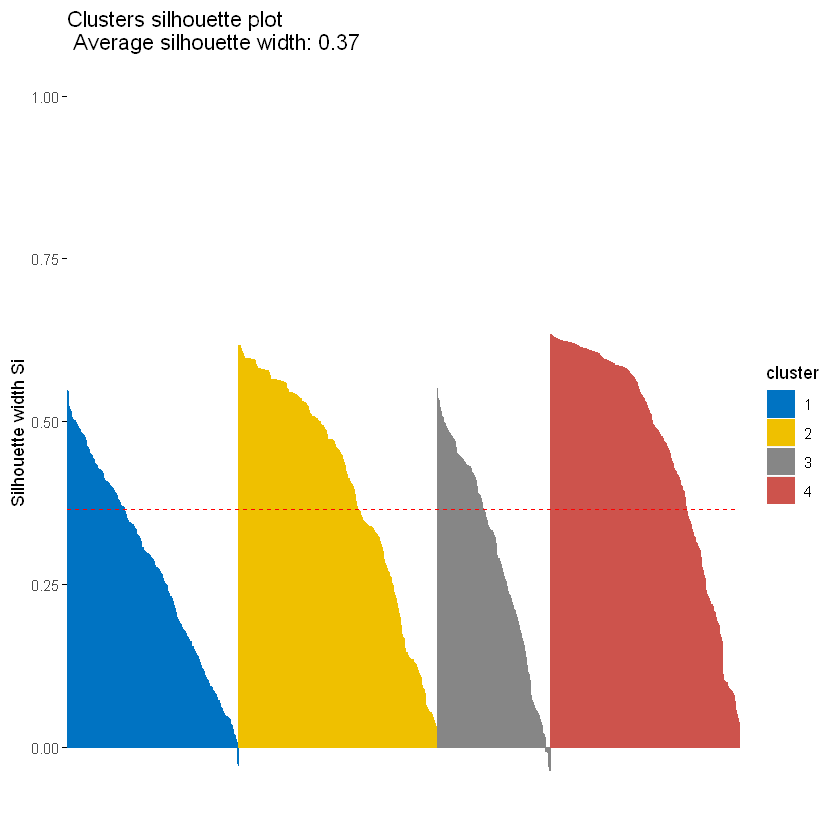

In [64]:
fviz_silhouette(km.res, palette = "jco", gtheme = theme_classic())

To investigate the differences further, we look at the mean summary of all features for each cluster.

In [71]:
  # Get average values of RFM and preferences per cluster
  users.behaviour = as.data.frame(sample.users[-1]) %>% 
    mutate(Cluster = km.res$cluster) %>% 
    group_by(Cluster) %>% summarise_all("mean") %>% 
    mutate_at(2:7, round, 0) %>%  
    mutate_at(8:12, round, 2)
  
  # Get average values of departments shopped from transaction data per cluster
  users.transactions = as.data.frame(user.data[-c(1, 23, 24, 25, 26, 27)]) %>% 
    mutate(Cluster = km.res$cluster) %>% 
    group_by(Cluster) %>% summarise_all("mean") %>% 
    mutate_at(2:22, round, 0)
  
  # Join the dataframes
  users.all = cbind(users.behaviour[-1], users.transactions[-c(1, 2)])   
  
  # Transpose for readability
  users.overall <- data.frame(t(users.all[-1]))
  colnames(users.overall) <- c(1, 2, 3, 4)
  
  # Print formatted table of behaviours.
  round(users.overall[1:4], 1)

,1,2,3,4
frequency,13.0,6.0,7.0,36.0
quantity,137.0,44.0,51.0,379.0
recency_score,7.0,9.0,3.0,3.0
freq_score,6.0,2.0,3.0,9.0
quantity_score,6.0,3.0,3.0,9.0
organic.pref,0.3,0.2,0.3,0.3
gluten.pref,0.4,0.2,0.2,0.6
veg.pref,0.1,0.0,0.0,0.1
dairy.pref,0.1,0.0,0.1,0.2
vegan.pref,0.1,0.0,0.0,0.2


We can imply the following behaviours in our Clusters:
1. Shops frequently, purchases in high volume and have not shopped, on average, for 18 days. 41% have a preference for gluten free products and 11% have a preference for dairy free. This consumer may be interested in sustainability and the environment. They buy snacks and beverages as well as staples. This should be targeted with some added offer such as free shipping or 10% off next purchase should be offered to reengage.
2.	Low frequency and volume and have not shopped recently, this is likely a new customer that was not retained by the service. They have no dietary preferences and shop mainly in Produce / Dairy & Eggs. Could be targeted with value promotions or free samples of high margin items. Customer journeys could be developed to increase retention of new customers.
3.	High volume and frequency customers but that have shopped recently. This group of customers are unlikely to churn. No need to target with special offers. Basket analysis could be carried out to upsell and increase the spend per transaction.
4.	Recent, low value, low volume customers. These customers buy staples. Customer journeys to develop these customers into brand advocates are necessary. Perhaps using an NPS survey or some incentivised qualitative measure. <br><br>
Our clustering has provided some immediately actionable insights for marketing teams to address. The clustering is successful in the sense that it has provided insight into the behaviour of customers. The addition of dietary needs does not appear to have added any significant benefit to the analysis. <br>
Transactional data is very similar across all groups, the same departments are by and large shopped by all clusters in similar proportion. There is massive scope for additional analysis such as tests of proportion and additional features.


### Conclusions and Future Work
This project has been a humbling experience. <br><br>
By working through each phase of this project, my assumptions have been continually challenged. The difficulty in letting go of my initial hypothesis that a correlation-based model was superior was substantial. I dedicated 5 – 10 hours of project time to researching quick fixes to the complexity issues with hierarchical clustering but in the end, repeatedly finding that it was not a scalable solution in the context of this problem. <br><br>
Dimensionality reduction and feature engineering was a difficult problem to overcome where it is trivial to add new features but adding meaningful features are significant is a very different prospect. My choice of dietary preferences was based, not entirely on significance, but also on interpretability. I had added day of week and time based preferences but this did not add any meaningful separation when the number of clusters was small. My goal was to keep the number of clusters as small as possible. <br><br>
Ultimately the most challenging part of the project was researching the acceptable limits of customer segmentation and gaining an understanding of the pros and cons of broad vs targeted segmentation and the instances in which either is preferable. <br><br>
Future work for this problem includes:
<li>Market Basket analysis
<li>Cross clustering versus transactional data. This is partially complete in the script for the project but needs to be built out and understood further.
<li>Additional feature engineering e.g. department groupings, clustering by aisles, ANOVA for aisle affinities.
<li>More extensive understanding of the relationship between departments in the transactional data and performing some dimensionality reduction activities.
<li>Better visualisation of the current solution to graphically explore the differences between each of the current clusters.
<li>Develop a parallelisable solution to use the whole dataset rather than just a sample.

__Note:__ The above steps were also carried out on the transactional data but the clustering was not as pronounced as with RFM. <br>
This code is available in the original R script. Additional feature investigation and manipulation is needed to be carried out. <br>